### Load Data

In [1]:
dir = 'data/full data/'

import os
import xml.etree.ElementTree as ET

#print all the files in the directory
excluded_files = []
for file_name in os.listdir(dir):
    try:
        tree = ET.parse(dir + file_name)
    except:
        excluded_files.append(file_name)
        print(file_name)
        continue
    

t1961-6-germany-togo-bit-1961.xml
t1963-6-germany-tunisia-bit-1963.xml
t1993-71-germany-slovenia-bit-1993.xml


### Meta Data Analysis

check if all the documents' metadata are in the same format

In [2]:
file1 = 'data/full data/t1990-14-canada-czech-republic-bit-1990.xml'
root = ET.parse(file1).getroot()
meta_data = root[0]
meta_data_children_template = set(child.tag for child in meta_data.getchildren())


C:\Users\Xiang\AppData\Local\Temp\ipykernel_14968\4210734556.py:4: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  meta_data_children_template = set(child.tag for child in meta_data.getchildren())


In [3]:
flag = True
n = 0

for file_name in os.listdir(dir):
    if file_name not in excluded_files:
        n += 1
        tree = ET.parse(dir + file_name)
        root = tree.getroot()
        meta_data = root[0]
        meta_data_children = set(child.tag for child in meta_data.getchildren())
        meta_data_children_template = meta_data_children_template.intersection(meta_data_children)


C:\Users\Xiang\AppData\Local\Temp\ipykernel_14968\1321602988.py:10: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  meta_data_children = set(child.tag for child in meta_data.getchildren())


In [4]:
n

3306

In [5]:
meta_data_children_template

{'code',
 'comments',
 'date_into_force',
 'date_signed',
 'date_terminated',
 'name',
 'partyisocode',
 'rev_date_into_force',
 'rev_date_signed',
 'side_date_into_force',
 'side_date_signed',
 'source',
 'termination_type',
 'type'}

we can see that all treadies have:
1. name
2. partyisocode
3. date_into_force
4. date_signed

now we tring to plot the distribution of date_signed in a histogram.

In [6]:
# store all meta data in a pandas dataframe
import pandas as pd

meta_data_df = pd.DataFrame(columns = ['code', 'name', 'date_into_force', 'date_signed', 'date_terminated', 'partyisocode0', 'partyisocode1'])
contries = set()

for file_name in os.listdir(dir):
    if file_name not in excluded_files:
        meta_data = ET.parse(dir + file_name).getroot()[0]
        row = [
            meta_data.find('code').text,
            meta_data.find('name').text,
            meta_data.find('date_into_force').text,
            meta_data.find('date_signed').text ,
            meta_data.find('date_terminated').text,
            ]
        partyisocode = [elem.text for elem in meta_data.findall('partyisocode')]
        contries.update(partyisocode)
        row += partyisocode[:2] # only take the first two parties, however there are more than two parties in ~30 treadies
        meta_data_df.loc[len(meta_data_df)] = row

In [7]:
meta_data_df.head()

,code,name,date_into_force,date_signed,date_terminated,partyisocode0,partyisocode1
0,T1959-1,Germany - Pakistan BIT (1959),1962-04-28,1959-11-25,None,DEU,PAK
1,T1960-2,Germany - Malaysia BIT (1960),1963-07-06,1960-12-22,None,DEU,MYS
2,T1961-2,Switzerland - Tunisia BIT (1961),1964-01-19,1961-12-02,2014-07-08,CHE,TUN
3,T1961-3,Germany - Greece BIT (1961),1963-07-15,1961-03-27,2021-10-29,DEU,GRC
4,T1961-4,Germany - Liberia BIT (1961),1967-10-22,1961-12-12,None,DEU,LBR


In [8]:
meta_data_df['date_signed'].isna().sum()

0

We are happy to see that there is no missing data in date_signed.

<AxesSubplot:xlabel='year', ylabel='count'>

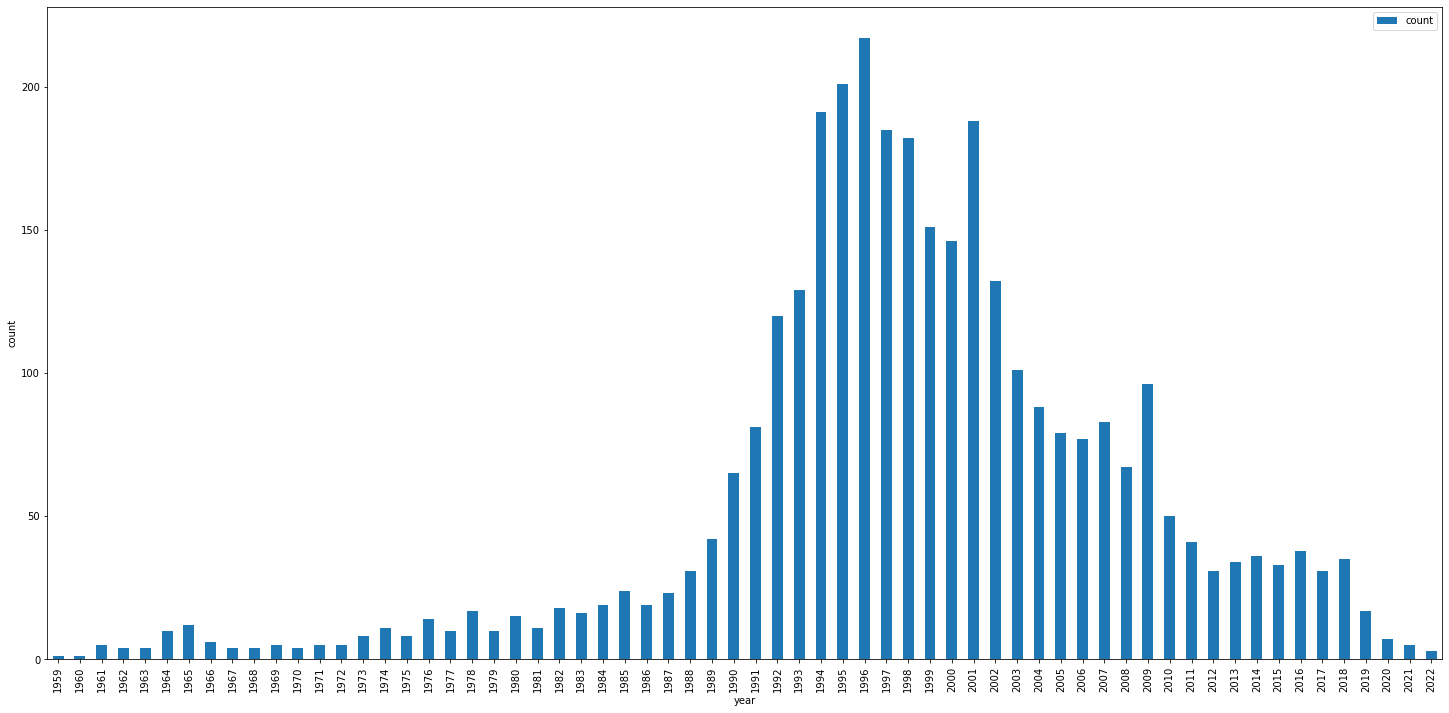

In [9]:
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'

# now plot the signed date
meta_data_df['date_signed'] = pd.to_datetime(meta_data_df['date_signed'])

# create a representation of the month with strfmt
meta_data_df['year_of_date_signed'] = meta_data_df['date_signed'].map(lambda dt: dt.strftime('%Y'))

grouped_df = meta_data_df.groupby('year_of_date_signed').size().to_frame("count").reset_index()
grouped_df.plot(kind='bar', x='year_of_date_signed', y='count', figsize=(25,12), xlabel = 'year', ylabel = 'count')


### Train Test Split

Initially we have ~3300 documents. We will use 3300 * 0.8 = 2640 for training and 3300 * 0.2 = 660 for testing. We found there are 2622 documents was signed before 2006 so we will use all the data prior to 2006 for training and the rest for testing.

In [10]:
sum(meta_data_df.year_of_date_signed <= '2005')

2622

Plot for partyisocode0

<AxesSubplot:xlabel='country', ylabel='count'>

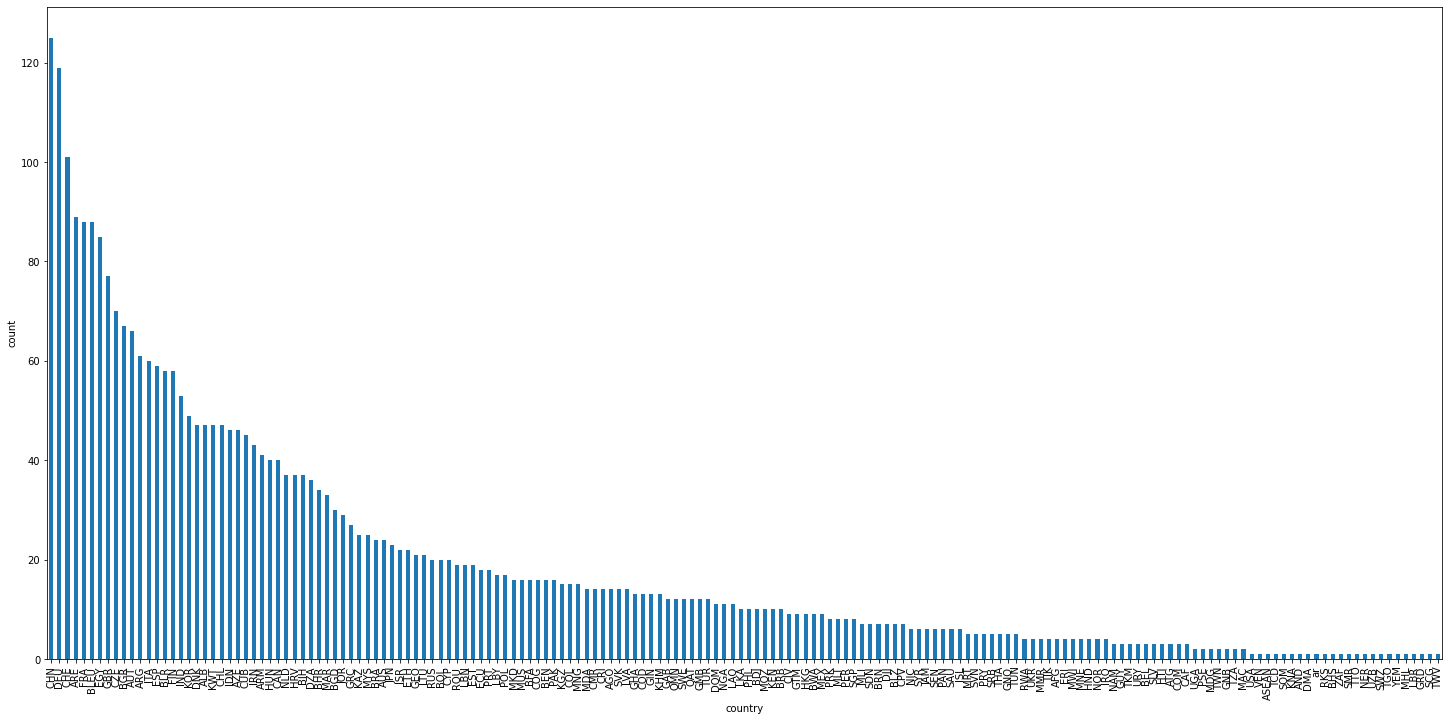

In [11]:
#plot country distribution
meta_data_df.partyisocode0.value_counts().plot(kind='bar', figsize=(25,12), xlabel = 'country', ylabel = 'count')

In [12]:
meta_data_df.partyisocode0

0       DEU
1       DEU
2       CHE
3       DEU
4       DEU
       ... 
3301    ARE
3302    CHN
3303    CHE
3304    ISR
3305    ARE
Name: partyisocode0, Length: 3306, dtype: object

Plot for partyisocode1

<AxesSubplot:xlabel='country', ylabel='count'>

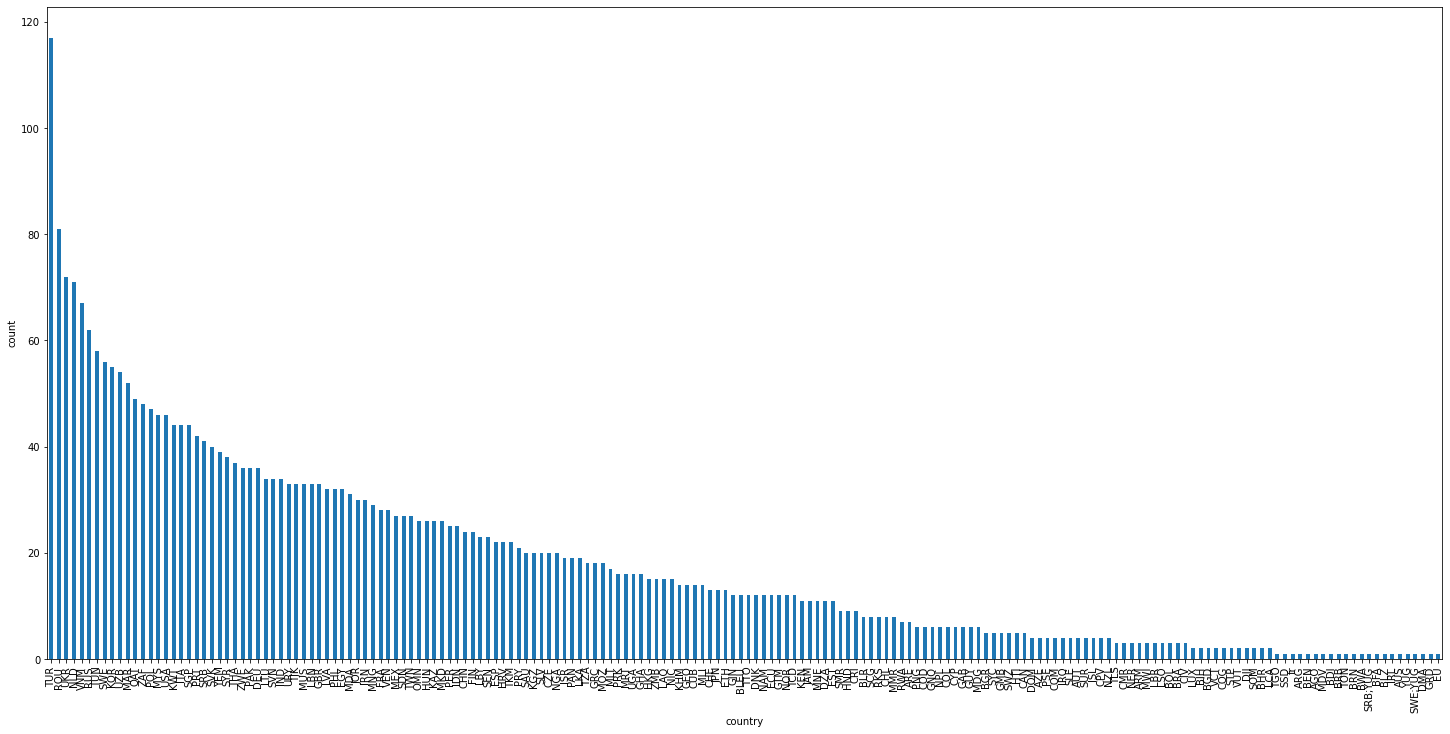

In [13]:
meta_data_df.partyisocode1.value_counts().plot(kind='bar', figsize=(25,12), xlabel = 'country', ylabel = 'count')

Now we combine the two parties.

In [14]:
meta_data_df.partyisocode1.values

array(['PAK', 'MYS', 'TUN', ..., 'IDN', 'PHL', 'PHL'], dtype=object)

In [15]:
import numpy as np
all_contries_involved = pd.DataFrame({'country' : np.hstack((meta_data_df.partyisocode0.values, meta_data_df.partyisocode1.values))})

<AxesSubplot:xlabel='country', ylabel='count'>

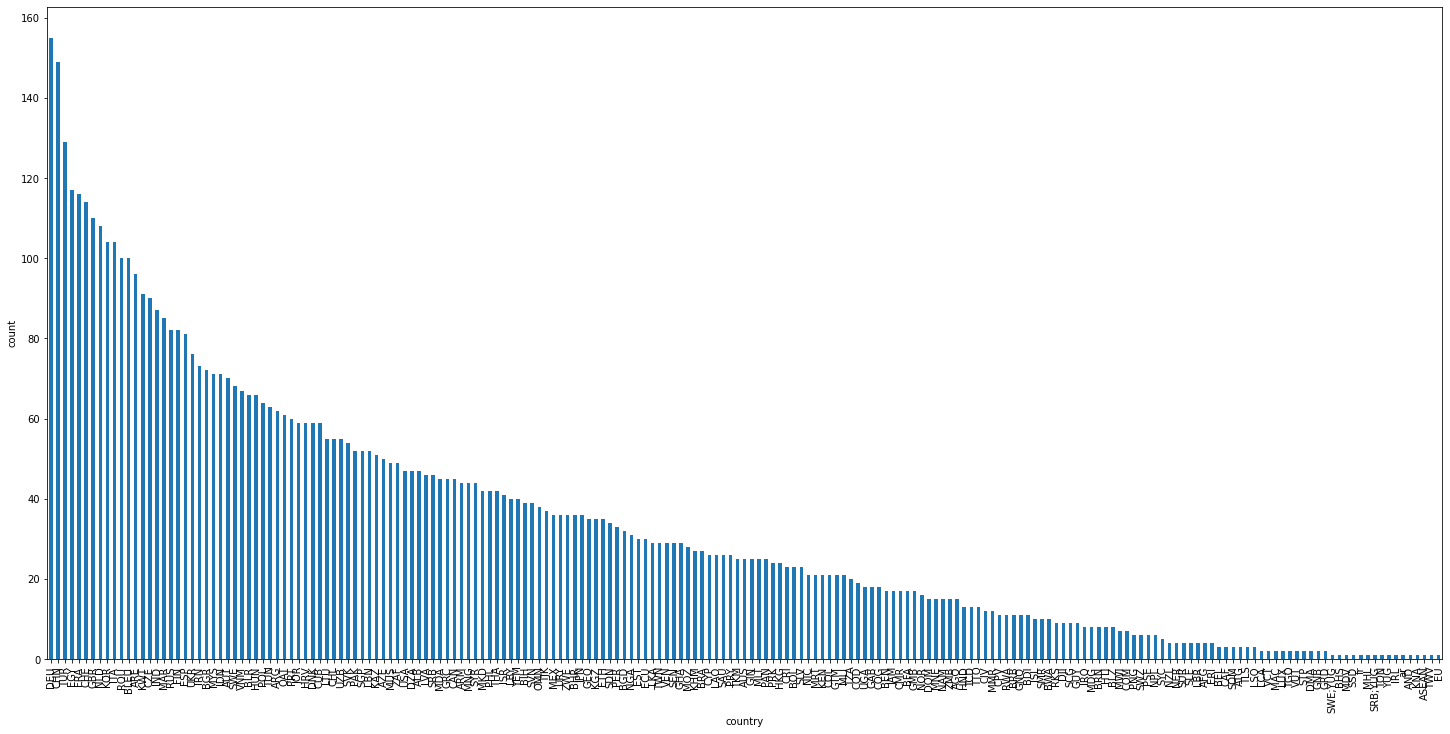

In [16]:
all_contries_involved.country.value_counts().plot(kind='bar', figsize=(25,12), xlabel = 'country', ylabel = 'count')

We can see that DEU and CHN appear the most frequently amoungt all the countries.

In [17]:
len(contries) == all_contries_involved.country.unique().shape[0]


True

Check how many articles don't have a title.

In [52]:
total_training_articles, total_testing_articles = 0, 0
total_training_articles_with_missing_topic, total_testing_articles_with_missing_topic = 0, 0

#iterate through all documents
for file_name in os.listdir(dir):
    try:
        root = ET.parse(dir + file_name).getroot()
        meta_data = root[0]
        doc_body = root[1][2]
        all_articles = doc_body.findall(".//div[@type='article']")
        year = int(meta_data.find('date_signed').text.split('-')[0])

        #check how many articles don't have a title
        for article in all_articles:
            if year < 2006:
                total_training_articles += 1
                if not article.get('title'):
                    total_training_articles_with_missing_topic += 1
            else:
                total_testing_articles += 1
                if not article.get('title'):
                    total_testing_articles_with_missing_topic += 1
                    print(file_name)
        
    except Exception as e:
        continue

t2006-24-belarus-slovenia-bit-2006.xml
t2006-24-belarus-slovenia-bit-2006.xml
t2006-24-belarus-slovenia-bit-2006.xml
t2006-24-belarus-slovenia-bit-2006.xml
t2006-36-china-russian-federation-bit-2006.xml
t2006-48-dominican-republic-netherlands-bit-2006.xml
t2006-48-dominican-republic-netherlands-bit-2006.xml
t2006-48-dominican-republic-netherlands-bit-2006.xml
t2006-48-dominican-republic-netherlands-bit-2006.xml
t2006-48-dominican-republic-netherlands-bit-2006.xml
t2006-48-dominican-republic-netherlands-bit-2006.xml
t2006-48-dominican-republic-netherlands-bit-2006.xml
t2006-48-dominican-republic-netherlands-bit-2006.xml
t2006-48-dominican-republic-netherlands-bit-2006.xml
t2006-48-dominican-republic-netherlands-bit-2006.xml
t2006-48-dominican-republic-netherlands-bit-2006.xml
t2006-48-dominican-republic-netherlands-bit-2006.xml
t2006-48-dominican-republic-netherlands-bit-2006.xml
t2006-48-dominican-republic-netherlands-bit-2006.xml
t2006-56-saudi-arabia-spain-bit-2006.xml
t2006-56-saudi

In [51]:
total_training_articles, total_testing_articles

(32298, 10280)

We can see from the above data, there are 32298 articles in training set and 10280 articles in testing set.

In [49]:
total_training_articles_with_missing_topic, total_testing_articles_with_missing_topic

(6700, 410)

The are 6700 articles in the training set has no title and 410 articles in the testing set has no title.